# Content-based Filtering Recommendation System

## 1. Environment Setup

### Import Libraries

- `pandas`: Used for exploring, cleaning, manipulating, and analysing data.  

- `re`: Used for forming a pattern for string matching.
- `matplotlib`: Used for creating visualisation to understand the data.
- `seaborn`: Used for creating visualisation, based on `matplotlib`.
- `nltk`: Used for handling language-related tasks.
  - `stopwords` (`nltk.corpus`): Used for filtering out common words (a, an, the).
  - `WordNetLemmatizer` - (`nltk.stem`): Used for reducing words to base or root form.
- `Counter` - (`collections`): Used for counting occurrences of elements in a collection.
- `TfidfVectorizer` - (`sklearn.feature_extraction.text`): Used for converting text data to weighted TF-IDF matrix.
- `MinMaxScaler` - (`sklearn.preprocessing`): Used for scaling features to a specified range, usually (0, 1).
- `NearestNeighbors` - (`sklearn.neighbors`): Used for finding nearest points in data using distance metrics.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [2]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

### Load Data

`movies.csv`:
- Key feature: `genres`.

`tags.csv`:
- Key feature: `tag`.

`ratings.csv`:
- Key feature: `rating`.

In [3]:
movies = pd.read_csv('MovieLens Dataset/movies.csv')
tags = pd.read_csv('MovieLens Dataset/tags.csv')
ratings = pd.read_csv('MovieLens Dataset/ratings.csv')

## 2. Data Exploration

### `movies.csv`

The `movies` DataFrame includes 3 columns:
- `movieId`: A unique integer for each distinct movie.  

- `title`: Movie title, including realease year.
- `genres`: A list of genres, separated by '`|`'.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Information about the `movies` DataFrame:
- Shape: (9743, 3)  

- 3 columns:
  - `movieId`: integer type, no missing values.  
  
  - `title`: object type, no missing values.
  - `genres`: object type, no missing values.

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9743 entries, 0 to 9742
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9743 non-null   int64 
 1   title    9743 non-null   object
 2   genres   9743 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


The `movies` DataFrame description:
- `movieId`:  

- `title`:
  - 9743 movies, but 9738 are unique.  

  - 5 duplicates with 2 occurrences each (freq = 2).
  - Example: `Emma (1996)`.
- `genres`:
  - 951 genres.  

  - Drama-only movie is the most popular with 1053 occurrences.

In [6]:
movies.describe(include='all')

,movieId,title,genres
count,9.743000e+03,9743,9743
unique,NaN,9738,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,4.353976e+04,NaN,NaN
std,1.421246e+05,NaN,NaN
min,1.000000e+00,NaN,NaN
25%,3.248500e+03,NaN,NaN
50%,7.301000e+03,NaN,NaN
75%,7.627200e+04,NaN,NaN


List of duplicates:

In [7]:
duplicate_titles = movies[['movieId', 'title']][movies.duplicated(subset=['title'], keep=False)]
print(duplicate_titles.sort_values(by='title'))

      movieId                                   title
4169     6003  Confessions of a Dangerous Mind (2002)
9106   144606  Confessions of a Dangerous Mind (2002)
650       838                             Emma (1996)
5601    26958                             Emma (1996)
5854    32600                             Eros (2004)
9135   147002                             Eros (2004)
2141     2851                         Saturn 3 (1980)
9468   168358                         Saturn 3 (1980)
5931    34048                War of the Worlds (2005)
6932    64997                War of the Worlds (2005)


In [8]:
all_genres = movies['genres'].str.get_dummies(sep='|')

Bar chart for top 10 genres:
- `Drama` is the most popular genre with over 4000 movies labelled as Drama.  

- `Comedy` follows by closely with slightly fewer movies.
- The other popular genres, in descending order, are Thriller, Action, Romance, Adventure, Crime, Sci-Fi, Horror, and Fantasy.

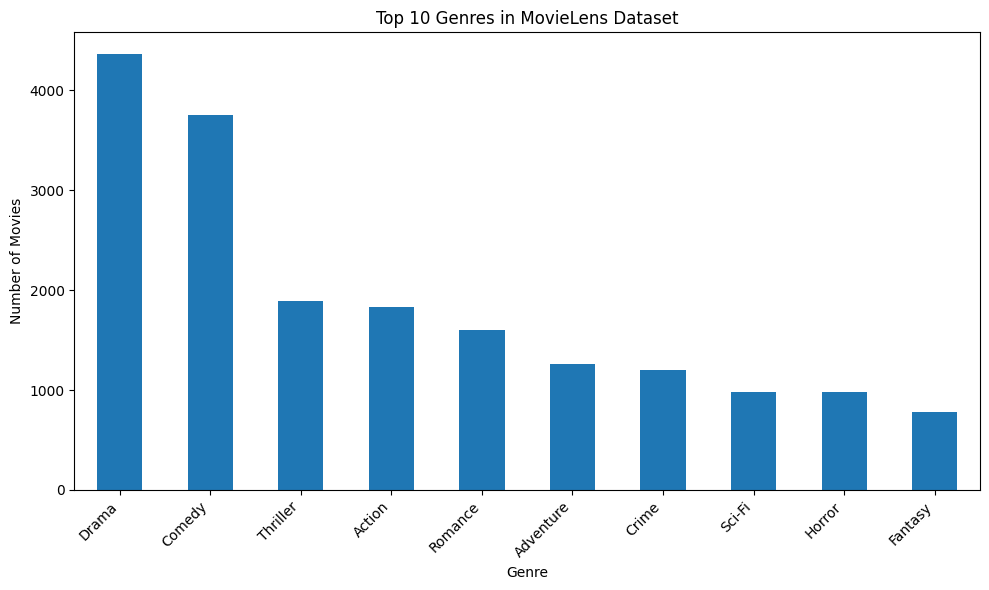

In [9]:
top_genres = all_genres.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar')
plt.title('Top 10 Genres in MovieLens Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Heatmap for the correlation between genres:
- Uses a binary color map, where darker colors indicate stronger correlations.  

- The highest correlation is 0.44 between the `Children` and `Animation`, indicating that these two genres often appear together in the dataset.
- This indicates that there is a large number of cartoons aimed at children in the dataset.

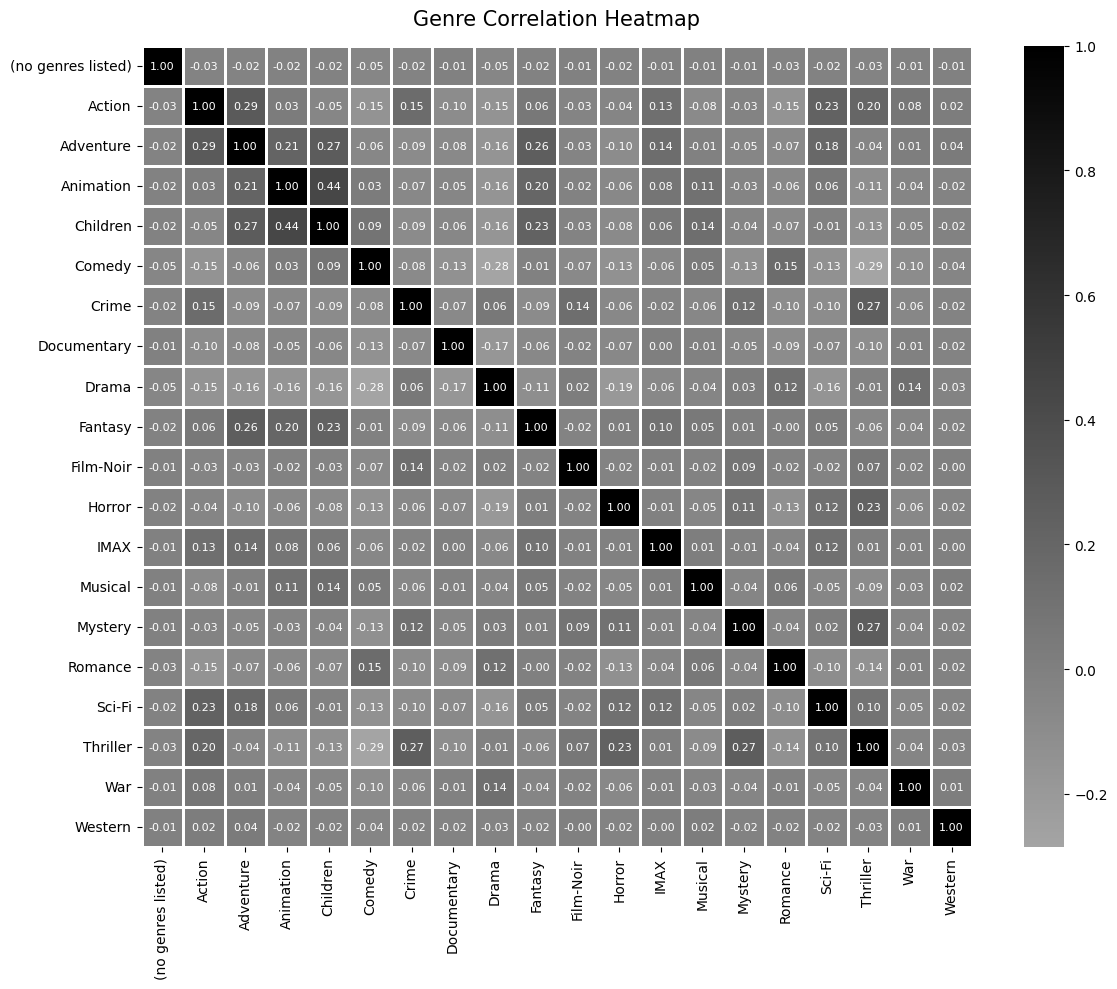

In [10]:
genre_correlation = all_genres.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    genre_correlation,
    annot=True,
    fmt=".2f",
    cmap='binary',
    center=0,
    linewidths=1,
    annot_kws={"size": 8}
)
plt.title('Genre Correlation Heatmap', fontsize=15, pad=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### `tags.csv`

The `tags` DataFrame includes 4 columns:
- `userId`: A unique integer for each distinct user.  

- `movieId`: A unique integer for each distinct movie.
- `tag`: Tag added by the user, which describes some aspect of the movie.
- `timestamp`: The time the tag was added, represented as Unix timestamp.

In [11]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Information about the `tag` DataFrame:
- Shape: (3684, 4)  

- 4 columns:
  - `userId`: integer type, no missing values.  
  
  - `movieId`: integer type, no missing values.
  - `tag`: object type, no missing values.
  - `timestamp`: integer type, no missing values.

In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3684 entries, 0 to 3683
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3684 non-null   int64 
 1   movieId    3684 non-null   int64 
 2   tag        3684 non-null   object
 3   timestamp  3684 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.3+ KB


The `tag` DataFrame description:
- `userId`:  

- `movieId`:
- `tag`:
  - 3684 tags added by users.  
  - The tag `In Netflix queue` is the most frequent, appearing 131 times.
- `timestamp`:

In [13]:
tags.describe(include='all')

,userId,movieId,tag,timestamp
count,3.684000e+03,3.684000e+03,3684,3.684000e+03
unique,NaN,NaN,1590,NaN
top,NaN,NaN,In Netflix queue,NaN
freq,NaN,NaN,131,NaN
mean,8.059156e+03,3.079836e+04,NaN,1.319681e+09
std,4.629892e+05,2.195976e+05,NaN,1.733905e+08
min,2.000000e+00,1.000000e+00,NaN,2.810202e+07
25%,4.240000e+02,1.262750e+03,NaN,1.137521e+09
50%,4.740000e+02,4.454000e+03,NaN,1.269833e+09
75%,4.770000e+02,3.929200e+04,NaN,1.498457e+09


### `ratings.csv`

The `ratings` DataFrame includes 4 columns:
- `userId`: A unique integer for each user.  

- `movieId`: A unique integer for each movie.
- `rating`: The rating given by the user to the movie, scale from 0.5 to 5.
- `timestamp`: The time the rating was provided, represented as Unix timestamp.

In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Information about the `movies` DataFrame:
- Shape: (100837, 4)  

- 4 columns:
  - `userId`: integer type, no missing values.  

  - `movieId`: integer type, no missing values.
  - `rating`: float type, no missing values.
  - `timestamp`: object type, no missing values.

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100837 entries, 0 to 100836
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100837 non-null  int64  
 1   movieId    100837 non-null  int64  
 2   rating     100837 non-null  float64
 3   timestamp  100837 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The `movies` DataFrame description:
- `userId`:  

- `movieId`:
- `rating`:
  - 100837 ratings in total, with the average of 3.5.
- `timestamp`:

In [16]:
ratings.describe(include='all')

,userId,movieId,rating,timestamp
count,1.008370e+05,1.008370e+05,100837.000000,1.008370e+05
mean,6.048118e+02,1.956494e+04,3.501572,1.205934e+09
std,8.849592e+04,5.437991e+04,1.042535,2.162918e+08
min,1.000000e+00,1.000000e+00,0.500000,2.810202e+07
25%,1.770000e+02,1.199000e+03,3.000000,1.019124e+09
50%,3.250000e+02,2.991000e+03,3.500000,1.186087e+09
75%,4.770000e+02,8.125000e+03,4.000000,1.435994e+09
max,2.810201e+07,1.309201e+07,5.000000,1.537799e+09


Bar chart for movie rating distribution:

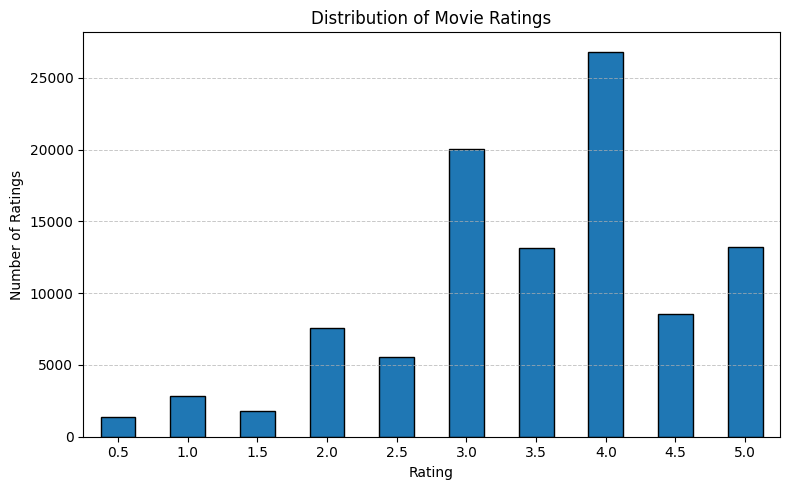

In [17]:
rating_counts = ratings['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
rating_counts.plot(kind='bar', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

plt.show()

Bar chart of the most frequently rated movies:

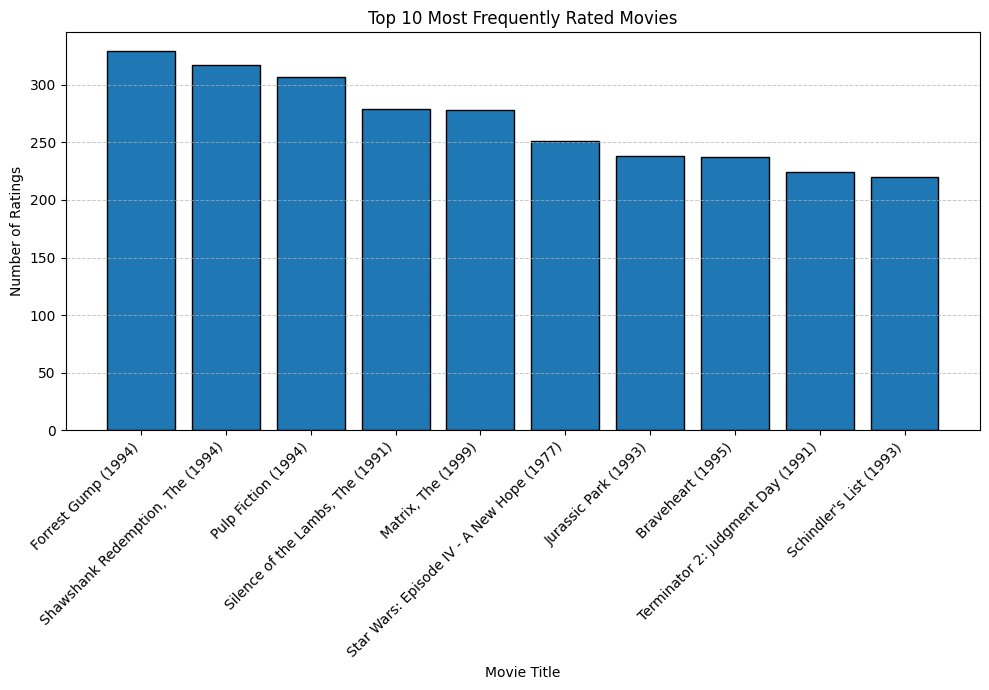

In [18]:
movie_rating_counts = ratings['movieId'].value_counts().head(10)
most_rated_movies = movie_rating_counts.reset_index()
most_rated_movies.columns = ['movieId', 'ratingCount']
most_rated_movies = most_rated_movies.merge(movies, on='movieId')

plt.figure(figsize=(10, 7))
plt.bar(most_rated_movies['title'], most_rated_movies['ratingCount'], edgecolor='black')
plt.title('Top 10 Most Frequently Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

plt.show()

## 3. Data Preprocessing

In [19]:
preprocessed_movies = movies[['movieId', 'title']].copy()

preprocessed_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


### Preprocess `genres`
- Split '`|`' from `genres` into more usable format for one-hot encoded matrix.  

- `Animation|Adventure|Comedy|Fantasy|Children` -> `[Animation, Adventure, Comedy, Fantasy, Children]`  
- Merge the matrix into `preprocessed_movies`.

In [20]:
movies['genres'] = movies['genres'].str.split('|')

genres_one_hot = movies['genres'].str.join('|').str.get_dummies()

genres_one_hot

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9741,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
preprocessed_movies = preprocessed_movies.join(genres_one_hot)

preprocessed_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Clean and Filter `tags.csv`
- Convert all tags to lowercase.  

- Remove non-aphabetical characters.
- Remove stopwords.
- Remove tag with > 20 characters.
- Lemmatisation.
- Remove duplicate tags.
- Filter `tag` with low frequency (<= 5).

In [22]:
tags['tag'] = tags['tag'].str.lower()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

stop_words = set(stopwords.words('english'))
tags['tag'] = tags['tag'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

tags = tags[tags['tag'].str.len() <= 20]

lemmatizer = WordNetLemmatizer()
tags['tag'] = tags['tag'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

tags = tags.drop_duplicates(subset=['movieId', 'tag'])

tag_counts = Counter(tags['tag'])
tags = tags[tags['tag'].apply(lambda x: tag_counts[x] > 5)]

tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
2,2,60756,ferrell,1445714992
6,2,106782,drug,1445715054
7,2,106782,leonardo dicaprio,1445715051
12,18,431,mafia,1462138755


### Preprocess `tag`
- Merge all tags associated with the corresponding movie based on `movieId`.  

- Create TF-IDF (Term Frequency-Inverse Document Frequency) vectoriser with 1309 feature maximum.
- Transform `tag` column into TF-IDF matrix.
- Convert the TF-IDF matrix to a DataFrame using `movieId`.
- Merge it into `preprocessed_movie` DataFrame.
- Replace all NaN value with 0.

In [23]:
tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
tags.head()

,movieId,tag
0,2,fantasy
1,5,pregnancy remake
2,7,remake
3,11,politics
4,14,politics


In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=1309)

tag_tfidf_matrix = tfidf_vectorizer.fit_transform(tags['tag'])

tag_tfidf_df = pd.DataFrame(tag_tfidf_matrix.toarray(), index=tags['movieId'], columns=tfidf_vectorizer.get_feature_names_out())

preprocessed_movies = pd.merge(preprocessed_movies, tag_tfidf_df, on='movieId', how='left')

preprocessed_movies.fillna(0, inplace=True)

preprocessed_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,twin,twist,vietnam,violence,visually,war,wedding,witty,world,york
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess `rating`
- Create a DataFrame that aggregates ratings by `movieId` and calculates the `average_rating` and the `popularity` (number of reviews).  

- Initialise a `MinMaxScaler` to normalize the `average_rating` and `popularity` columns.
- Merge it into `preprocessed_movies`.

In [25]:
ratings_agg = ratings.groupby('movieId').agg(average_rating=('rating', 'mean'), popularity=('rating', 'count')).reset_index()

ratings_agg.head()

,movieId,average_rating,popularity
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,4,2.357143,7
4,5,3.071429,49


In [26]:
scaler = MinMaxScaler()

ratings_agg[['average_rating']] = scaler.fit_transform(ratings_agg[['average_rating']])

ratings_agg[['popularity']] = scaler.fit_transform(ratings_agg[['popularity']])

ratings_agg.head()

,movieId,average_rating,popularity
0,1,0.760207,0.652439
1,2,0.651515,0.332317
2,3,0.613248,0.155488
3,4,0.412698,0.018293
4,5,0.571429,0.146341


In [27]:
preprocessed_movies = pd.merge(preprocessed_movies, ratings_agg, on='movieId', how='left')

preprocessed_movies.fillna(0, inplace=True)

preprocessed_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,vietnam,violence,visually,war,wedding,witty,world,york,average_rating,popularity
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.760207,0.652439
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651515,0.332317
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.613248,0.155488
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412698,0.018293
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.146341


## 4. Apply K-Nearest Neighbors

- Extract `genres` and `tag` into a separate array by removing the first 2 columns (`movieId`, `title`) and the last 2 columns (`average_rating`, `popularity`).

- Extract `average_rating` and `popularity` into 2 separate arrays.
- Set the weights (importance) for each array:
  - `genres` + `tag` = 0.6 (60%).  

  - `average_rating` = 0.2 (20%)
  - `popularity` = 0.2 (20%)
- Combine the arrays of features into one array `weighted_features`.

In [28]:
genre_tag_features = preprocessed_movies.iloc[:, 2:-2].values
rating_features = preprocessed_movies[['average_rating']].values
popularity_features = preprocessed_movies[['popularity']].values

genre_tag_features

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
genre_tag_weight = 0.6
rating_weight = 0.2
popularity_weight = 0.2

weighted_features = np.hstack((
    genre_tag_features * genre_tag_weight,
    rating_features * rating_weight,
    popularity_features * popularity_weight
))

weighted_features

array([[0.        , 0.        , 0.6       , ..., 0.        , 0.15204134,
        0.1304878 ],
       [0.        , 0.        , 0.6       , ..., 0.        , 0.13030303,
        0.06646341],
       [0.        , 0.        , 0.        , ..., 0.        , 0.12264957,
        0.03109756],
       ...,
       [0.        , 0.6       , 0.        , ..., 0.        , 0.13333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15555556,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2       ,
        0.        ]])

- Initialize KNN with cosine similarity metric.  

- Fit model with `weighted_features` data.
- Create a function to find similar movies.
- Find movieId based on movie name.
- Extract features of the selected movie.
- Find nearest neighbors (movies) using KNN.
- Get movieId of similar movies.
- Merge data needed to return.
- Return a DataFrame containing recommended movies.

In [30]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(weighted_features)

NearestNeighbors(algorithm='brute', metric='cosine')

In [31]:
def get_similar_movies(movie_title, k=260):
    movie_idex = preprocessed_movies[preprocessed_movies['title'] == movie_title].index[0]

    movie_features = weighted_features[movie_idex].reshape(1, -1)

    distances, indices = knn.kneighbors(movie_features, n_neighbors=k + 1)

    similarity_scores = 1 - distances.flatten()[1:]

    similar_movie_ids = preprocessed_movies.iloc[indices.flatten()[1:]]['movieId']

    similar_movies = pd.merge(similar_movie_ids.to_frame(), movies[['movieId', 'genres']], on='movieId', how='left')

    similar_movies = pd.merge(similar_movies, tags[['movieId', 'tag']], on='movieId', how='left')

    similar_movies = pd.merge(similar_movies, ratings_agg[['movieId', 'average_rating', 'popularity']], on='movieId', how='left')

    similar_movies = pd.merge(similar_movies, preprocessed_movies[['movieId', 'title']], on='movieId', how='left')

    similar_movies['similarity_score'] = similarity_scores

    similar_movies = similar_movies[['movieId', 'title', 'genres', 'tag', 'average_rating', 'popularity', 'similarity_score']]

    return similar_movies

- Select a movie (`Toy Story (1995)`) and put it into the function.  

- The function returns a DataFrame suggesting similar movies.

In [32]:
similar_movies_df = get_similar_movies('Toy Story (1995)')
similar_movies_df

,movieId,title,genres,tag,average_rating,popularity,similarity_score
0,4886,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]",NaN,0.749158,0.399390,0.999305
1,2294,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,0.609877,0.134146,0.996836
2,4016,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]",NaN,0.714715,0.109756,0.996773
3,53121,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,0.560847,0.060976,0.995762
4,166461,Moana (2016),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,0.655556,0.027439,0.995628
...,...,...,...,...,...,...,...
255,44225,Aquamarine (2006),"[Children, Comedy, Fantasy]",NaN,0.333333,0.003049,0.771761
256,173873,Gulliver's Travels (1996),"[Adventure, Children, Fantasy]",NaN,0.333333,0.000000,0.771705
257,95193,Pocahontas II: Journey to a New World (1998),"[Adventure, Animation, Children]",NaN,0.333333,0.000000,0.771705
258,2876,Thumbelina (1994),"[Animation, Children, Fantasy]",NaN,0.333333,0.000000,0.771705
